# cross-section weights of 1/efficiency

In [1]:
import sys; sys.path.insert(0, '../../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
from Xsec_tools import *
%matplotlib inline

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


## load mc and data

In [2]:
versions['overlay date'] = '2018_09_22'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'
versions['data date'] = '2018_08_16'
versions['beam on'] = 'prod_reco_optfilter_bnb_v12_unblind_mcc8'
versions['beam off'] = 'prod_reco_optfilter_extbnb_v12_mcc8_dev'
selected_overlay,selected_overlay_concat,selected_CC1p,genie_CC1p,selected_beam_on,selected_beam_off = load_mc_and_data()

did not find selected_cosmic.csv, so creating it...
285038 ccqe candidate pairs, 180092 in FV
74392 are 1mu-1p, 41.3%
55230 are other-pairs, 30.7%
155416 are cosmic, 86.3%
--------------------------------------------------------------
37228 are CC1p, 20.7%
I finished loading overlay samples. We have in total 285038 pairs
applied cuts to overlay
saved selected 1mu-1p to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_09_22_selected_1mu-1p.csv
saved selected other-pairs to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_09_22_selected_other-pairs.csv
saved selected cosmic to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_09_22_selected_cosmic.csv
saved selected CC1p to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018

In [3]:
afro_genie_dict = dict()
afro_genie_CC1p_dict = dict()
afro_genie_CC1p_nocut_dict = dict()
path = '/Users/erezcohen/Desktop/uBoone/CCQEanalysis/afro_genie_samples/'
genie_list = ['nominal','hA2015','hA_SRC','hA_Tune3']#,'hN2015'
for gname in genie_list: 
    afro_genie_dict[gname] = pd.read_csv(path + 'CC_4_9E20_POT_mA_0_99'+'_'+gname+'.csv')
    print 'loaded',gname
    afro_genie = afro_genie_dict[gname]
    afro_genie_contained = afro_genie[(afro_genie.IsCC_1p_200MeVc==True)
                        & ((afro_genie.v_x>3) & (afro_genie.v_x<256))                        
                        & ((afro_genie.v_y>-115) & (afro_genie.v_y<115))                        
                        & ((afro_genie.v_z>5) & (afro_genie.v_z<1037))                        
                       ]
    afro_genie_in_limits = sample_in_limits(sam=afro_genie_contained
                                   ,varPmu='truth_Pmu',varPmu_cos_theta='truth_Pmu_cos_theta'
                                   ,varPp='truth_Pp',varPp_cos_theta='truth_Pp_cos_theta')
    afro_genie_CC1p = afro_genie_in_limits[afro_genie_in_limits['IsCC_1p_200MeVc']==True]
    print len(afro_genie_CC1p),'afro GENIE CC1p'
    afro_genie_CC1p_nocut_dict[gname] = afro_genie_CC1p
    # kinematical cuts
    delta_theta_12=55  # deg.
    delta_Delta_phi=35 # deg.
    Pt_max=0.35        # GeV/c
    afro_genie_CC1p_in_cuts = afro_genie_CC1p[(np.abs(afro_genie_CC1p['theta_12']-90)<delta_theta_12)
                                              &(afro_genie_CC1p['Pt']<Pt_max)
                                              &(np.abs(afro_genie_CC1p['delta_phi']-180.)<delta_Delta_phi)]
    print len(afro_genie_CC1p_in_cuts),'afro GENIE CC1p in kinematical cuts'
    afro_genie_CC1p_dict[gname] = afro_genie_CC1p_in_cuts    

loaded nominal
33695 afro GENIE CC1p
25833 afro GENIE CC1p in kinematical cuts
loaded hA2015
34478 afro GENIE CC1p
25918 afro GENIE CC1p in kinematical cuts
loaded hA_SRC
30607 afro GENIE CC1p
23167 afro GENIE CC1p in kinematical cuts
loaded hA_Tune3
33312 afro GENIE CC1p
27348 afro GENIE CC1p in kinematical cuts


## computation of effiency weights

In [4]:
for key in Limits.keys(): Bins[key] = np.linspace(Limits[key][0],Limits[key][1],NBins+1)
bins1,bins2,bins3 = Bins['Pmu'], Bins['cos(theta(mu))'] , Bins['phi(mu)']
N1,N2,N3 = len(bins1)-1,len(bins2)-1,len(bins3)-1

In [5]:
print linspace(-0.65,0.8,7)
Bins['cos(theta(mu))'] = np.array([-0.65,-0.4083,-0.167,0.075,0.317,0.5583, 0.8, 0.95])
print linspace(0.15,0.8,7)
Bins['cos(theta(p))'] = np.array([ 0.15 ,  0.2583,  0.366,  0.475 ,  0.583, 0.692,  0.8, 0.95])

[-0.65       -0.40833333 -0.16666667  0.075       0.31666667  0.55833333
  0.8       ]
[ 0.15        0.25833333  0.36666667  0.475       0.58333333  0.69166667
  0.8       ]


In [6]:
def compute_eff_weights(beam_on=None,beam_off=None
                       ,generated_CC1p=None,selected_CC1p=None,overlay=None
                       ,NBins=7
                        ,bins_cos_theta_mu = None
                        ,bins_cos_theta_p = None
                       ,option=None
                       ,ob_1='Pmu',ob_2='cos(theta(mu))',ob_3='phi(mu)'
                       ,reco_1='reco_Pmu_mcs',reco_2='reco_Pmu_cos_theta',reco_3='reco_Pmu_mcs_phi'
                       ,true_1='truth_Pmu',true_2='truth_Pmu_cos_theta',true_3='truth_Pmu_phi'
                       # for fixing muon bins
                       ,do_in_kin_cuts=True
                       ,delta_theta_12=55  # deg.
                       ,delta_Delta_phi=35 # deg.                
                       ,Pt_max=0.35        # GeV/c
                       ,debug=0
                      ):
    # the return is a dictionary of results    
    for key in Limits.keys(): Bins[key] = np.linspace(Limits[key][0],Limits[key][1],NBins+1)
    if bins_cos_theta_mu is not None: Bins['cos(theta(mu))'] = bins_cos_theta_mu; 
    if bins_cos_theta_p is not None: Bins['cos(theta(p))'] = bins_cos_theta_p 
    global bins1,bins2,bins3,N1,N2,N3
    bins1,bins2,bins3 = Bins[ob_1], Bins[ob_2] , Bins[ob_3]
    N1,N2,N3 = len(bins1)-1,len(bins2)-1,len(bins3)-1
    N,List = dict(),dict()
    for i_P in range(N1):#{
        Pmin,Pmax = bins1[i_P],bins1[i_P+1]

        for i_cos_theta in range(N2):#{
            cos_theta_min,cos_theta_max = bins2[i_cos_theta],bins2[i_cos_theta+1]

            for i_phi in range(N3):#{
                phi_min,phi_max = bins3[i_phi],bins3[i_phi+1]
                
                N['on'],List['on'] = len_sam_in_3d_bin(beam_on,
                                               reco_1,Pmin,Pmax,
                                               reco_2,cos_theta_min,cos_theta_max,
                                               reco_3,phi_min,phi_max)
                
                N['off'],List['off'] = len_sam_in_3d_bin(beam_off,
                                               reco_1,Pmin,Pmax,
                                               reco_2,cos_theta_min,cos_theta_max,
                                               reco_3,phi_min,phi_max)

                N['generated'],List['generated'] = len_sam_in_3d_bin(generated_CC1p,
                                               true_1,Pmin,Pmax,
                                               true_2,cos_theta_min,cos_theta_max,
                                               true_3,phi_min,phi_max)
                generated_CC1p_in_kin_cuts = generated_CC1p[(np.abs(generated_CC1p['theta_12']-90)<delta_theta_12)                                              
                                                            &(generated_CC1p['Pt']<Pt_max)
                                                            &(np.abs(np.abs(generated_CC1p['delta_phi'])-180.)<delta_Delta_phi)]
                N['gen. in kin. cuts'],List['gen. in kin. cuts'] = len_sam_in_3d_bin(generated_CC1p_in_kin_cuts,
                                               true_1,Pmin,Pmax,
                                               true_2,cos_theta_min,cos_theta_max,
                                               true_3,phi_min,phi_max)

                N['CC1p'],List['CC1p'] = len_sam_in_3d_bin(selected_CC1p,
                                               reco_1,Pmin,Pmax,
                                               reco_2,cos_theta_min,cos_theta_max,
                                               reco_3,phi_min,phi_max)

                
                N['overlay'],List['overlay'] = len_sam_in_3d_bin(overlay,
                                               reco_1,Pmin,Pmax,
                                               reco_2,cos_theta_min,cos_theta_max,
                                               reco_3,phi_min,phi_max)
                
                Ngen = N['gen. in kin. cuts'] if do_in_kin_cuts else N['generated']
                eff, eff_err = get_eff(Ngen=Ngen , Nsel=N['CC1p'])
                    
                # efficiency weight assigned to the event
                w,werr=0,0
                if eff>0:
                    w = 1.e39/(eff*flux*Ntargets)
                    werr = 1.e39*eff_err/(eff*eff*flux*Ntargets)
                    
                if debug:
                    print 'phi_min,phi_max:',phi_min,phi_max
                    print N['CC1p'],'CC1p',N['gen. in kin. cuts'],'gen. in kin. cuts'
                    print 'eff=',eff,'+/-',eff_err
                    print 'w=',w,'+/-',werr
                
                beam_on.loc[List['on'],ob_1+' weight'] = w
                beam_on.loc[List['on'],ob_1+' weight err'] = werr
                
                beam_off.loc[List['off'],ob_1+' weight'] = w
                beam_off.loc[List['off'],ob_1+' weight err'] = werr

                selected_CC1p.loc[List['CC1p'],ob_1+' weight'] = w
                selected_CC1p.loc[List['CC1p'],ob_1+' weight err'] = werr
                
                overlay.loc[List['overlay'],ob_1+' weight'] = w
                overlay.loc[List['overlay'],ob_1+' weight err'] = werr                
            #} i_phi
        #} i_cos_theta
    #} i_P
    print 'done.'  
    return 

In [7]:
compute_eff_weights(debug=0,NBins=7,
                    bins_cos_theta_mu = Bins['cos(theta(mu))'],
                    bins_cos_theta_p = Bins['cos(theta(p))'],
                       beam_on=selected_beam_on,
                       beam_off=selected_beam_off,                       
                       generated_CC1p=genie_CC1p,                       
                       selected_CC1p=selected_CC1p ,                       
                       overlay=selected_overlay_concat) 

done.


In [8]:
compute_eff_weights(debug=0,NBins=7,
                    bins_cos_theta_mu = Bins['cos(theta(mu))'],
                    bins_cos_theta_p = Bins['cos(theta(p))'],
                       beam_on=selected_beam_on,
                       beam_off=selected_beam_off,                       
                       generated_CC1p=genie_CC1p,                       
                       selected_CC1p=selected_CC1p ,                       
                       overlay=selected_overlay_concat
                       ,ob_1='Pp',ob_2='cos(theta(p))',ob_3='phi(p)'
                       ,reco_1='reco_Pp',reco_2='reco_Pp_cos_theta',reco_3='reco_Pp_phi'
                       ,true_1='truth_Pp',true_2='truth_Pp_cos_theta',true_3='truth_Pp_phi')

done.


# plot Xsec.

## The value and uncertainty in weighted distributions

$$N_j = \sum_{i\in j}(1\times w_i)$$

$$\Delta N_j
=
\sqrt{\sum_{i\in j} \left[\left( 1 \times \Delta w_i \right)^2 + \left(\sqrt{1} \times w_i \right)^2\right]}
=
\sqrt{\sum_{i\in j}\left(  \Delta w_i ^2 +  w_i^2 \right)}
$$



In [31]:
def get_Xsec_1d(beam_on=None,beam_off=None,overlay=None,CC1p=None,
                var='reco_Pmu_mcs',bins=Bins['Pmu'],bin_width=None,wname='Pmu weight',
                mul=1,
                do_corr_phi_0=False):
    h=dict()
    for sam,slabel in zip([beam_on,beam_off,overlay,CC1p]                       
                          ,['beam on','beam off','overlay','CC1p']):
        h[slabel],h[slabel+' err']=np.zeros(len(bins)-1),np.zeros(len(bins)-1)
        for i in range(len(bins)-1):
            sam_in_bin = sam[(bins[i]<=mul*sam[var])& (mul*sam[var]<bins[i+1])]
            h[slabel][i] = np.sum(sam_in_bin[wname])
            if do_corr_phi_0:
                h[slabel][i] = np.sum(sam_in_bin[wname]*sam_in_bin['W(corr. phi~0)'])                
            h[slabel+' err'][i] = np.sqrt(np.sum(np.square(sam_in_bin[wname+' err'])
                                                 +np.square(sam_in_bin[wname])))
            
    h['B'] = h['overlay'] - h['CC1p']
    h['B err'] = np.sqrt(np.square(h['overlay err']) + np.square(h['CC1p err']))

    h['B scaled'] = h['B']*Nevents['f(POT)']
    h['B scaled err'] = h['B err']*Nevents['f(POT)']

    #     print "h['beam off err']:",h['beam off err']
    h['beam off scaled'] = h['beam off']*OffBeam_scaling
    h['beam off scaled err'] = h['beam off err']*OffBeam_scaling

    h['N(on)-N(off)-B'] = h['beam on'] - h['beam off scaled'] - h['B scaled']
    h['N(on)-N(off)-B err'] = np.sqrt(np.square(h['beam on err'])
                                      + np.square(h['beam off scaled err'])
                                      + np.square(h['B scaled err']))
    h['Xsec'] = h['N(on)-N(off)-B']/bin_width
    h['Xsec err'] = h['N(on)-N(off)-B err']/bin_width
    
    h['Xsec beam on'] = h['beam on']/bin_width
    h['Xsec beam on err'] = h['beam on err']/bin_width
                          
    # foc CC1p (mc-Xsec) we want no correction applied
    for i in range(len(bins)-1):
        CC1p_in_bin = CC1p[(bins[i]<=mul*CC1p[var])& (mul*CC1p[var]<bins[i+1])]
        h['CC1p'][i] = np.sum(CC1p_in_bin[wname])
    h['mc Xsec'] = h['CC1p']*Nevents['f(POT)']/bin_width
    h['mc Xsec err'] = h['CC1p err']*Nevents['f(POT)']/bin_width    
    return h

In [32]:
def get_Xsecs(do_corr_phi_0=False, debug=0, do_proton=True, do_muon=True, do_P=True, do_cos_theta=True, do_phi=True, do_print_Xsec=True,
              remove_last_cos_theta_mu_bin=False):
    Xsec_dict = dict()
    for particle,do_particle in zip(['mu','p']
                                    ,[do_muon,do_proton]):
        if do_particle==False: continue
        if debug: print 'getting cross-section with P'+particle+' weight'
        for i,(observable,true,ivar,do_var) in enumerate(zip(['P'+particle,'cos(theta('+particle+'))','phi('+particle+')']
                                                          ,['truth_P'+particle,'truth_P'+particle+'_cos_theta','truth_P'+particle+'_phi']
                                                          ,[(1,4),(2,5),(3,6)]
                                                             ,[do_P,do_cos_theta,do_phi])):
            if do_var==False: continue
            var,bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)
            mul = 180./np.pi if 'phi' in observable else 1
            beam_on , beam_off , overlay , CC1p = selected_beam_on,selected_beam_off,selected_overlay_concat,selected_CC1p
            if remove_last_cos_theta_mu_bin:
                beam_on = beam_on[beam_on['reco_Pmu_cos_theta']<Bins['cos(theta(mu))'][-2]]
                beam_off = beam_off[beam_off['reco_Pmu_cos_theta']<Bins['cos(theta(mu))'][-2]]
                overlay = overlay[overlay['reco_Pmu_cos_theta']<Bins['cos(theta(mu))'][-2]]
                CC1p = CC1p[CC1p['reco_Pmu_cos_theta']<Bins['cos(theta(mu))'][-2]]

            h = get_Xsec_1d(beam_on,beam_off,overlay,CC1p
                            ,var=var,bins=Bins[observable],bin_width=bin_width,wname='P'+particle+' weight',mul=mul
                            ,do_corr_phi_0=do_corr_phi_0)
            if i==0 and do_print_Xsec: print ('integrated Xsec: %.2f+/-%.2f'%(np.sum(h['Xsec']*bin_width),np.sqrt(np.sum(np.square(h['Xsec err'])*bin_width))),
                            'mc Xsec: %.2f+/-%.2f'%(np.sum(h['mc Xsec']*bin_width),np.sqrt(np.sum(np.square(h['mc Xsec err'])*bin_width))))
            if debug>1:  pp.pprint(h)
            Xsec_dict[observable+' beam on'] = h['Xsec beam on']
            Xsec_dict[observable+' beam on err'] = h['Xsec beam on err']
            Xsec_dict[observable] = h['Xsec']
            Xsec_dict[observable+' err'] = h['Xsec err']
            Xsec_dict['mc '+observable] = h['mc Xsec']
            Xsec_dict['mc '+observable+' err'] = h['mc Xsec err']
        plt.tight_layout()
    return Xsec_dict

In [37]:
def draw_Xsecs(do_add_afro_genie = True, do_corr_phi_0=False, debug=0, do_proton=True, do_muon=True, 
               do_P=True, do_cos_theta=True, do_phi=True,
               do_add_beam_on=False):

    Xsec_dict = get_Xsecs(do_corr_phi_0=do_corr_phi_0, debug=debug, do_proton=do_proton, do_muon=do_muon, do_P=do_P, do_cos_theta=do_cos_theta, do_phi=do_phi)
    Xsec_remove_last_cos_theta_mu_bin = get_Xsecs(do_corr_phi_0=do_corr_phi_0, debug=debug, do_proton=do_proton, do_muon=do_muon, do_P=do_P, do_cos_theta=do_cos_theta, do_phi=do_phi,
                          remove_last_cos_theta_mu_bin=True)
    for particle,do_particle in zip(['mu','p']
                                    ,[do_muon,do_proton]):
        if do_particle==False: continue
        if debug: print 'drawing cross-section with P'+particle+' weight'
        fig=plt.figure(figsize=(24,8))
        for i,(observable,true,ivar,do_var) in enumerate(zip(['P'+particle,'cos(theta('+particle+'))','phi('+particle+')']
                                                          ,['truth_P'+particle,'truth_P'+particle+'_cos_theta','truth_P'+particle+'_phi']
                                                          ,[(1,4),(2,5),(3,6)]
                                                             ,[do_P,do_cos_theta,do_phi])):
            if do_var==False: continue
            if debug: print observable
            var,bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)
            mul = 180./np.pi if 'phi' in observable else 1
            h = dict()
            h['beam on'],h['beam on err'] = Xsec_dict[observable+' beam on'],Xsec_dict[observable+' beam on err']
            h['Xsec'],h['Xsec err'] = Xsec_dict[observable],Xsec_dict[observable+' err']
            h['mc Xsec'],h['mc Xsec err'] = Xsec_dict['mc '+observable], Xsec_dict['mc '+observable+' err']

            ax = fig.add_subplot(3,3,ivar)
            if do_add_beam_on:
                plt.errorbar(x=mid,xerr=0.5*bin_width,y=h['beam on'],yerr=h['beam on err'],color='violet',fmt='o')

            plt.errorbar(x=mid,xerr=0.5*bin_width,y=h['Xsec'],yerr=h['Xsec err'],color=Colors['beam on'],fmt='o')
            ax.bar( x=mid , height=2*h['mc Xsec err'], bottom=h['mc Xsec']-h['mc Xsec err'], width=bin_width, color=Colors['CC1p'])
            if do_add_afro_genie:#{
                for gname,ls in zip(genie_list,['-','--','-.',':']):#{
                    afro_genie_CC1p = afro_genie_CC1p_dict[gname]  
                    if i==0:                    
                        afro_Xsec,afro_Xsec_err = compute_Xsec(Non=len(afro_genie_CC1p), Non_err=np.sqrt(len(afro_genie_CC1p)))
                        print gname,'afro genie Xsec: %.2f ± %.2f'%(afro_Xsec*4.908e19/4.9e20,afro_Xsec_err*4.908e19/4.9e20),'e-39 cm2' 
                    h_genie,_ = np.histogram(mul*afro_genie_CC1p[true],bins=bins)
                    h_genie_err = np.sqrt(h_genie)
                    genie_Xsec,genie_Xsec_err = np.zeros((len(bins)-1)), np.zeros((len(bins)-1))
                    for i_bin in range(len(bins)-1):
                        genie_Xsec[i_bin],genie_Xsec_err[i_bin] = compute_Xsec(Non=h_genie[i_bin]*4.908e19/4.9e20, Non_err=h_genie_err[i_bin]*4.908e19/4.9e20,
                                                                               eff=1, bin_width=bin_width[i_bin] )
                    mystep(x=mid ,x_width=bin_width, y=genie_Xsec, y_width=genie_Xsec_err,
                           color='black',linestyle=ls,linewidth=3,label=r'genie ('+gname+')')    
                #}
            #}
            set_axes(ax,'',y_label=(r'$\frac{d\sigma}{d'+vlabel+'}$' 
                                    +(r'$\left[10^{-39} \frac{cm^{2}}{%s}\right]$'%units if units is not None 
                                      else r'$\left[10^{-39}cm^{2}\right]$'))
                     ,do_add_grid=True,remove_ticks_x=True                                         
                     ,ylim=(0,1.1*np.max(ax.get_ylim()))
                    )
            # remove the last cos(theta) bin
            if 'Pmu_cos_theta' in var:
                plt.plot([bins[-2],bins[-2]],ax.get_ylim(),'--',color='black')

            # residuals plot
            den, den_err = h['Xsec']-h['mc Xsec'],np.sqrt(np.square(h['Xsec err'])+np.square(h['mc Xsec err']))
            num, num_err = h['Xsec'],h['mc Xsec err']
            ratio = den/num
            ax = fig.add_subplot(3,3,7+i)
            ratio_err = ratio*np.sqrt(np.square(den_err/den) + np.square(num_err/num))
            plt.errorbar(x=mid,xerr=0.5*bin_width,y=ratio,yerr=ratio_err,fmt='o',markersize=0,color='black')
            chi2,ndf = chi2_two_data_curves(h1=h['Xsec'],h1err=h['Xsec err'],h2=h['mc Xsec'],h2err=h['mc Xsec err'],bins=bins,debug=0)
            plt.text(mid[0],0.98*np.min(ax.get_ylim()) + 0.04*np.max(ax.get_ylim()), r'$\chi^2/ndf=%.2f/%d$'%(chi2,ndf), fontsize=20)
            set_axes(ax,xlabel,y_label=r'(data-mc)/data',do_add_grid=True)
            plt.plot([np.min(bins),np.max(bins)],[0,0],'--',color='royalblue')

            
            # remove the last cos(theta) bin
            if 'Pmu_cos_theta' in var:
                plt.plot([bins[-2],bins[-2]],ax.get_ylim(),'--',color='black')
        plt.tight_layout(h_pad=0.0)
        plt.subplots_adjust(hspace=0.05)
                                
        print 'without last cos(theta(mu)) bin'                
        fig=plt.figure(figsize=(24,8))
        for i,(observable,true,ivar,do_var) in enumerate(zip(['P'+particle,'cos(theta('+particle+'))','phi('+particle+')']                                                          
                                                             ,['truth_P'+particle,'truth_P'+particle+'_cos_theta','truth_P'+particle+'_phi']                                                          
                                                             ,[(1,4),(2,5),(3,6)]                                                             
                                                             ,[do_P,False,do_phi])):
            if do_var==False: continue
            var,bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)
            mul = 180./np.pi if 'phi' in observable else 1
            h = dict()
            h['beam on'],h['beam on err'] = Xsec_remove_last_cos_theta_mu_bin[observable+' beam on'],Xsec_remove_last_cos_theta_mu_bin[observable+' beam on err']
            h['Xsec'],h['Xsec err'] = Xsec_remove_last_cos_theta_mu_bin[observable],Xsec_remove_last_cos_theta_mu_bin[observable+' err']
            h['mc Xsec'],h['mc Xsec err'] = Xsec_remove_last_cos_theta_mu_bin['mc '+observable], Xsec_remove_last_cos_theta_mu_bin['mc '+observable+' err']

            ax = fig.add_subplot(3,3,ivar)
            if do_add_beam_on:
                plt.errorbar(x=mid,xerr=0.5*bin_width,y=h['beam on'],yerr=h['beam on err'],color='violet',fmt='o')
                
            plt.errorbar(x=mid,xerr=0.5*bin_width,y=h['Xsec'],yerr=h['Xsec err'],color=Colors['beam on'],fmt='o')
            ax.bar( x=mid , height=2*h['mc Xsec err'], bottom=h['mc Xsec']-h['mc Xsec err'], width=bin_width, color=Colors['CC1p'])
            if do_add_afro_genie:#{
                for gname,ls in zip(genie_list,['-','--','-.',':']):#{
                    afro_genie_CC1p = afro_genie_CC1p_dict[gname]  
                    afro_genie_CC1p = afro_genie_CC1p[afro_genie_CC1p['truth_Pmu_cos_theta']<Bins['cos(theta(mu))'][-2]]
                    if i==0:                    
                        afro_Xsec,afro_Xsec_err = compute_Xsec(Non=len(afro_genie_CC1p), Non_err=np.sqrt(len(afro_genie_CC1p)))
                        print gname,'afro genie Xsec: %.2f ± %.2f'%(afro_Xsec*4.908e19/4.9e20,afro_Xsec_err*4.908e19/4.9e20),'e-39 cm2' 
                    h_genie,_ = np.histogram(mul*afro_genie_CC1p[true],bins=bins)
                    h_genie_err = np.sqrt(h_genie)
                    genie_Xsec,genie_Xsec_err = np.zeros((len(bins)-1)), np.zeros((len(bins)-1))
                    for i_bin in range(len(bins)-1):
                        genie_Xsec[i_bin],genie_Xsec_err[i_bin] = compute_Xsec(Non=h_genie[i_bin]*4.908e19/4.9e20, Non_err=h_genie_err[i_bin]*4.908e19/4.9e20,
                                                                               eff=1, bin_width=bin_width[i_bin] )
                    mystep(x=mid ,x_width=bin_width, y=genie_Xsec, y_width=genie_Xsec_err,
                           color='black',linestyle=ls,linewidth=3,label=r'genie ('+gname+')')    
                #}
            #}
            set_axes(ax,'',y_label=(r'$\frac{d\sigma}{d'+vlabel+'}$' 
                                    +(r'$\left[10^{-39} \frac{cm^{2}}{%s}\right]$'%units if units is not None 
                                      else r'$\left[10^{-39}cm^{2}\right]$'))
                     ,do_add_grid=True,remove_ticks_x=True                                         
                     ,ylim=(0,1.1*np.max(ax.get_ylim()))
                    )

            # residuals plot
            den, den_err = h['Xsec']-h['mc Xsec'],np.sqrt(np.square(h['Xsec err'])+np.square(h['mc Xsec err']))
            num, num_err = h['Xsec'],h['mc Xsec err']
            ratio = den/num
            ax = fig.add_subplot(3,3,7+i)
            ratio_err = ratio*np.sqrt(np.square(den_err/den) + np.square(num_err/num))
            plt.errorbar(x=mid,xerr=0.5*bin_width,y=ratio,yerr=ratio_err,fmt='o',markersize=0,color='black')
            chi2,ndf = chi2_two_data_curves(h1=h['Xsec'],h1err=h['Xsec err'],h2=h['mc Xsec'],h2err=h['mc Xsec err'],bins=bins,debug=0)
            plt.text(mid[0],0.98*np.min(ax.get_ylim()) + 0.04*np.max(ax.get_ylim()), r'$\chi^2/ndf=%.2f/%d$'%(chi2,ndf), fontsize=20)
            set_axes(ax,xlabel,y_label=r'(data-mc)/data',do_add_grid=True)
            plt.plot([np.min(bins),np.max(bins)],[0,0],'--',color='royalblue')
        print
        plt.tight_layout(h_pad=0.0)
        plt.subplots_adjust(hspace=0.05)
    return Xsec_dict

# correct $\phi_\mu ~ 0$ and $\phi_p ~ 0$ 
using external weights applied to the events in these bins

In [17]:
# iterative process for correction
for sam in [selected_beam_on,selected_beam_off,selected_CC1p,selected_overlay_concat]:
    sam['W(corr. phi~0)'] = 1
# Xsec_dict = draw_Xsecs(do_add_afro_genie=False ,do_corr_phi_0=True,debug=0);
Xsec_dict = get_Xsecs( do_corr_phi_0=False , debug=0, do_print_Xsec=False )
correction, correction_arrays = dict(),dict()
correction_arrays['mu'] = []; correction_arrays['p'] = []; step=[]
correction['mu'] = correction['p'] = 1
current_correction = 10
i = 1
while np.abs(current_correction-1)>0.001:
    step.append(i)
    for particle,var in zip(['mu','p'],
                            ['reco_Pmu_mcs_phi','reco_Pp_phi']):
        Xsec,Xsec_err = Xsec_dict['phi('+particle+')'],Xsec_dict['phi('+particle+') err']
        bins = Bins['phi('+particle+')']
        N = len(bins)-1; n = N/2
        Xsec_phi_0 = Xsec[n]
        Xsec_phi_not_0 = np.concatenate([Xsec[:n-1],Xsec[n+1:]])
        Xsec_err_phi_not_0 = np.concatenate([Xsec_err[:n-1],Xsec_err[n+1:]])
        mean_phi_not_0 = np.average(Xsec_phi_not_0 , weights=1./np.square(Xsec_err_phi_not_0))
        current_correction = mean_phi_not_0/Xsec_phi_0
        correction[particle] = correction[particle]*current_correction
        correction_arrays[particle].append( correction[particle] )
        print 'correction for phi('+particle+')~0:',current_correction
        for sam in [selected_beam_on,selected_beam_off,selected_CC1p,selected_overlay_concat]:
            indices_phi_0 = sam.index[(bins[n] <= 180./np.pi*sam[var]) & (180./np.pi*sam[var] < bins[n+1])].tolist()
            sam.loc[indices_phi_0,'W(corr. phi~0)'] = sam.loc[indices_phi_0,'W(corr. phi~0)'] * current_correction
        Xsec_dict = get_Xsecs( do_corr_phi_0=True , debug=0, do_print_Xsec=False )
        print 'corrected samples for ',particle,', computing Xsec'
#         Xsec_dict = draw_Xsecs(do_proton=True, do_add_afro_genie = False ,do_corr_phi_0=True,debug=0);
    i = i+1
print 'done.'

correction for phi(mu)~0: 3.03583942037
corrected samples for  mu , computing Xsec
correction for phi(p)~0: 1.4395562346
corrected samples for  p , computing Xsec
correction for phi(mu)~0: 1.04933462848
corrected samples for  mu , computing Xsec
correction for phi(p)~0: 1.0145604472
corrected samples for  p , computing Xsec
correction for phi(mu)~0: 1.00224195433
corrected samples for  mu , computing Xsec
correction for phi(p)~0: 1.00068436169
corrected samples for  p , computing Xsec
done.


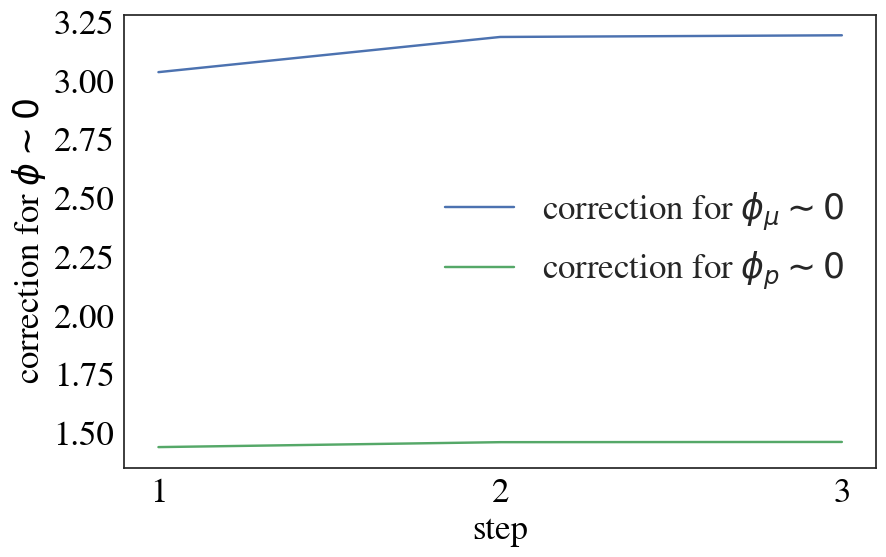

In [13]:
fig,ax=plt.subplots(figsize=(9.7,6))
plt.plot(step,correction_arrays['mu'],label=r'correction for $\phi_\mu \sim  0$')
plt.plot(step,correction_arrays['p'],label=r'correction for $\phi_p \sim 0$')
set_axes(ax,r'step',r'correction for $\phi \sim  0$',do_add_legend=True,xticks=[1,2,3])
plt.savefig('/Users/erezcohen/Desktop/phi_0_correction.pdf')

('integrated Xsec: 4.56+/-0.81', 'mc Xsec: 5.34+/-0.14')
('integrated Xsec: 4.51+/-1.33', 'mc Xsec: 5.13+/-0.21')
('integrated Xsec: 3.72+/-0.74', 'mc Xsec: 3.54+/-0.12')
('integrated Xsec: 3.69+/-1.24', 'mc Xsec: 3.37+/-0.17')
nominal afro genie Xsec: 5.75 ± 0.04 e-39 cm2
hA2015 afro genie Xsec: 5.77 ± 0.04 e-39 cm2
hA_SRC afro genie Xsec: 5.16 ± 0.03 e-39 cm2
hA_Tune3 afro genie Xsec: 6.09 ± 0.04 e-39 cm2
without last cos(theta(mu)) bin
nominal afro genie Xsec: 3.83 ± 0.03 e-39 cm2
hA2015 afro genie Xsec: 3.83 ± 0.03 e-39 cm2
hA_SRC afro genie Xsec: 3.46 ± 0.03 e-39 cm2
hA_Tune3 afro genie Xsec: 4.31 ± 0.03 e-39 cm2

nominal afro genie Xsec: 5.75 ± 0.04 e-39 cm2
hA2015 afro genie Xsec: 5.77 ± 0.04 e-39 cm2
hA_SRC afro genie Xsec: 5.16 ± 0.03 e-39 cm2
hA_Tune3 afro genie Xsec: 6.09 ± 0.04 e-39 cm2
without last cos(theta(mu)) bin
nominal afro genie Xsec: 3.83 ± 0.03 e-39 cm2
hA2015 afro genie Xsec: 3.83 ± 0.03 e-39 cm2
hA_SRC afro genie Xsec: 3.46 ± 0.03 e-39 cm2
hA_Tune3 afro genie Xs

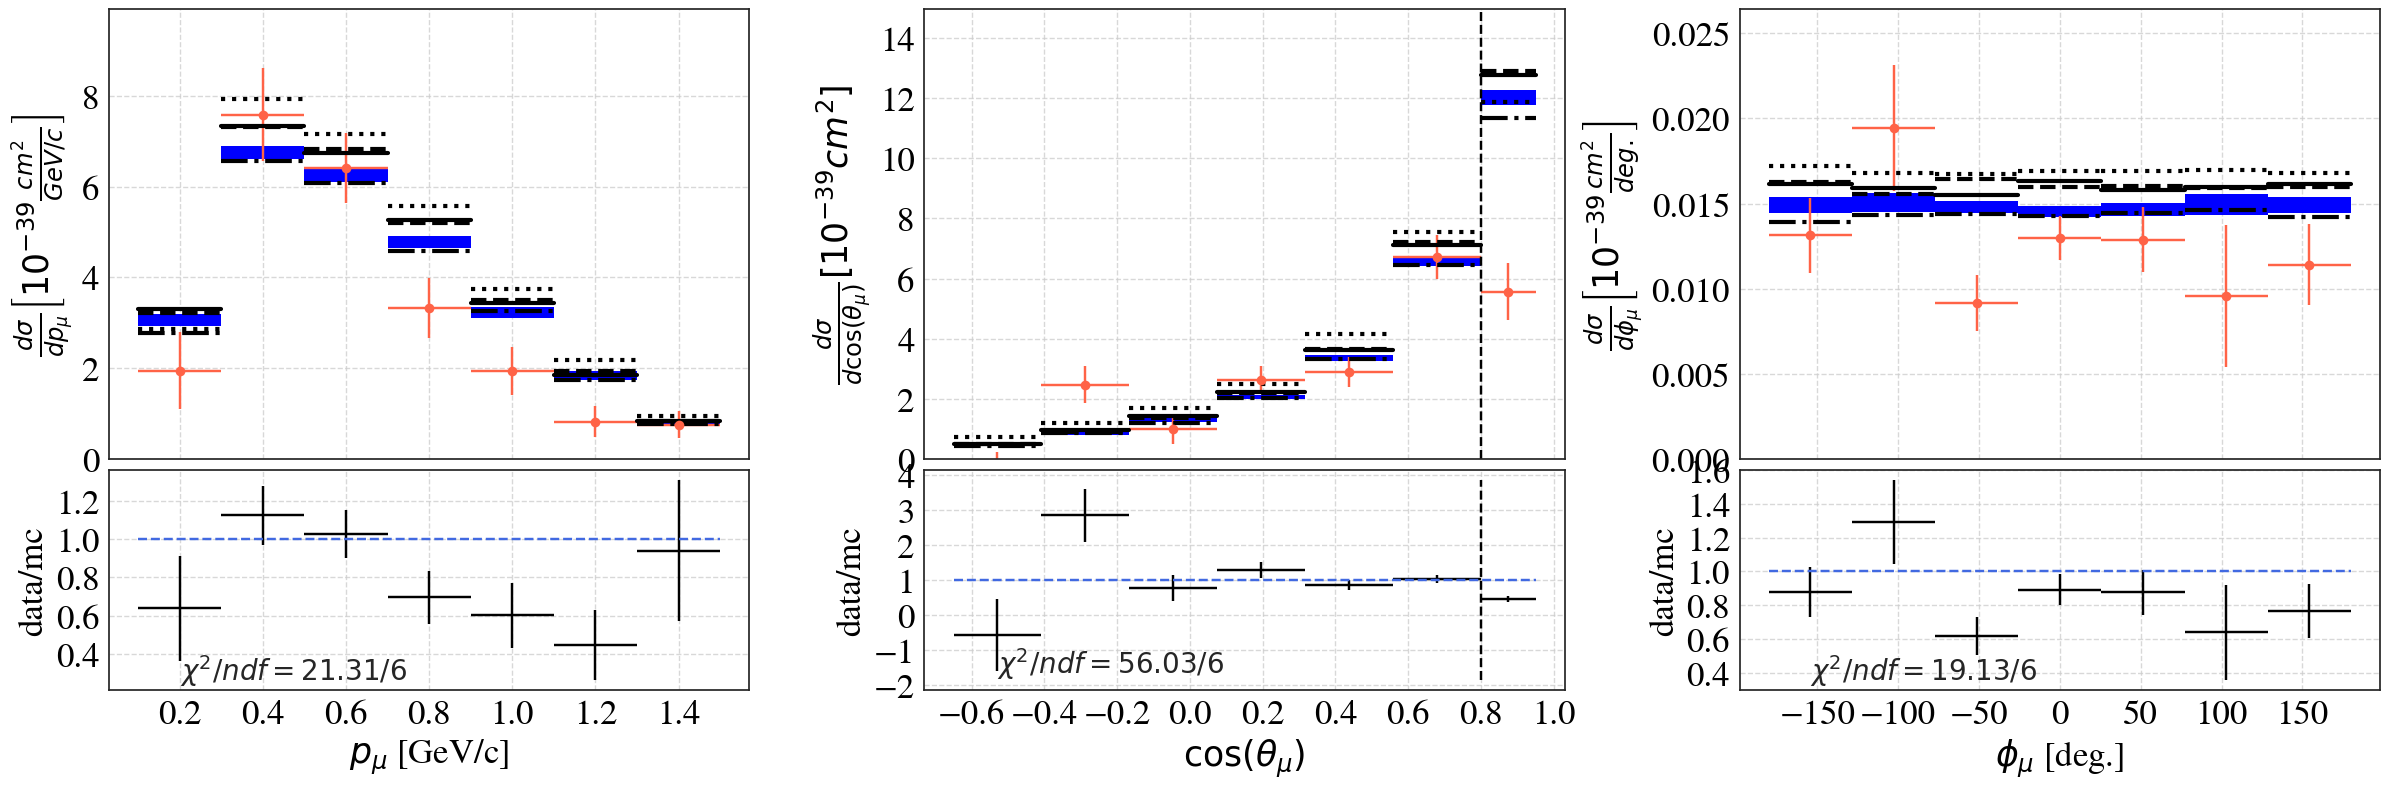

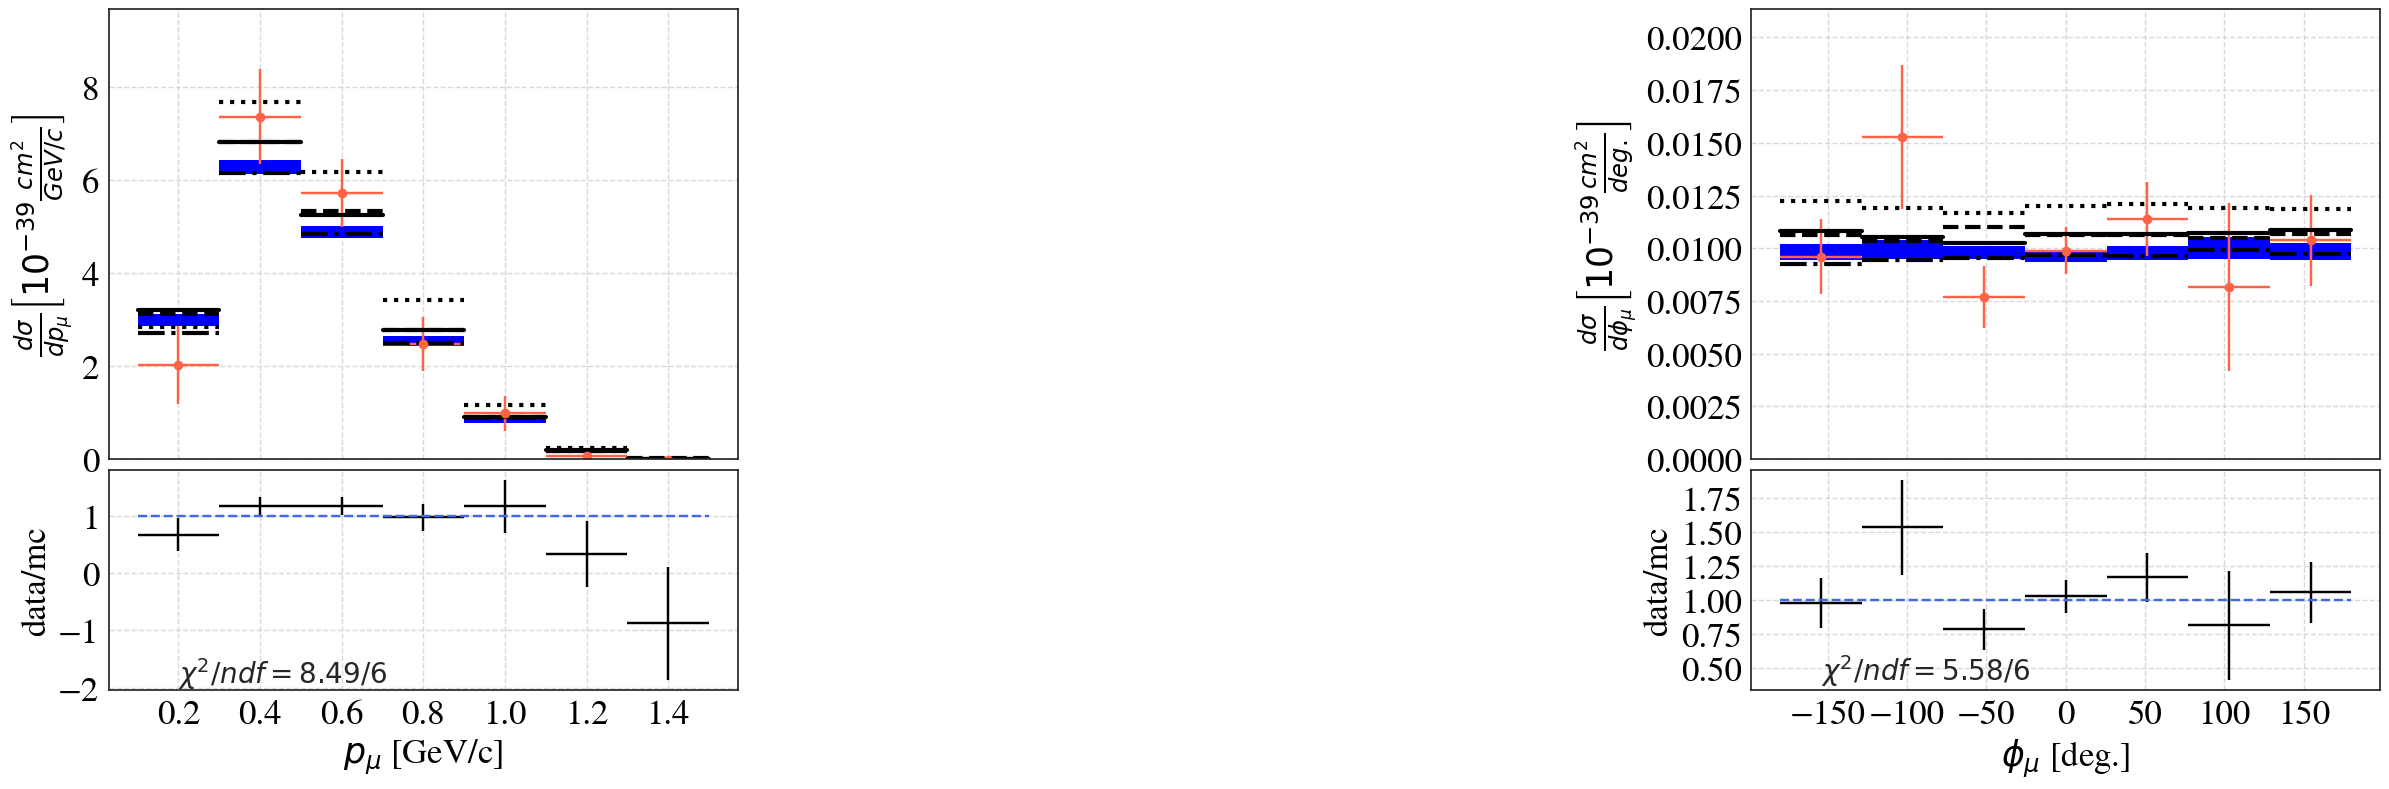

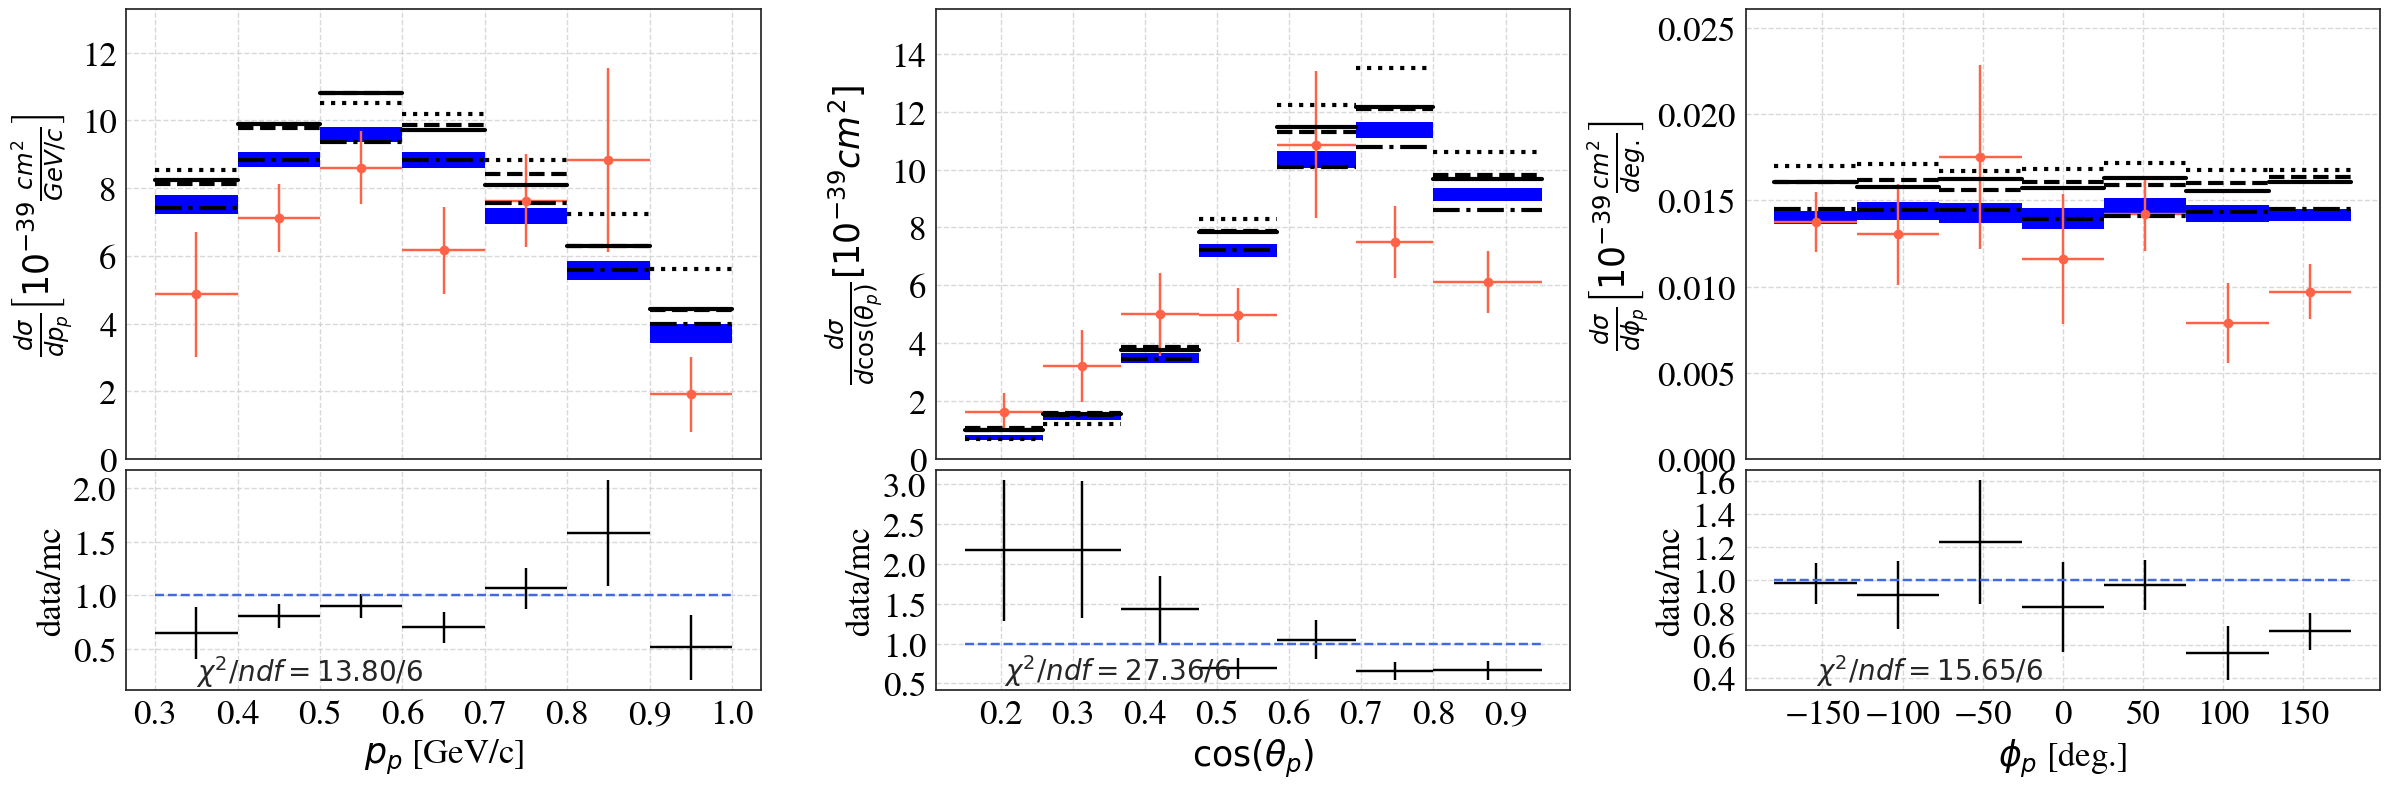

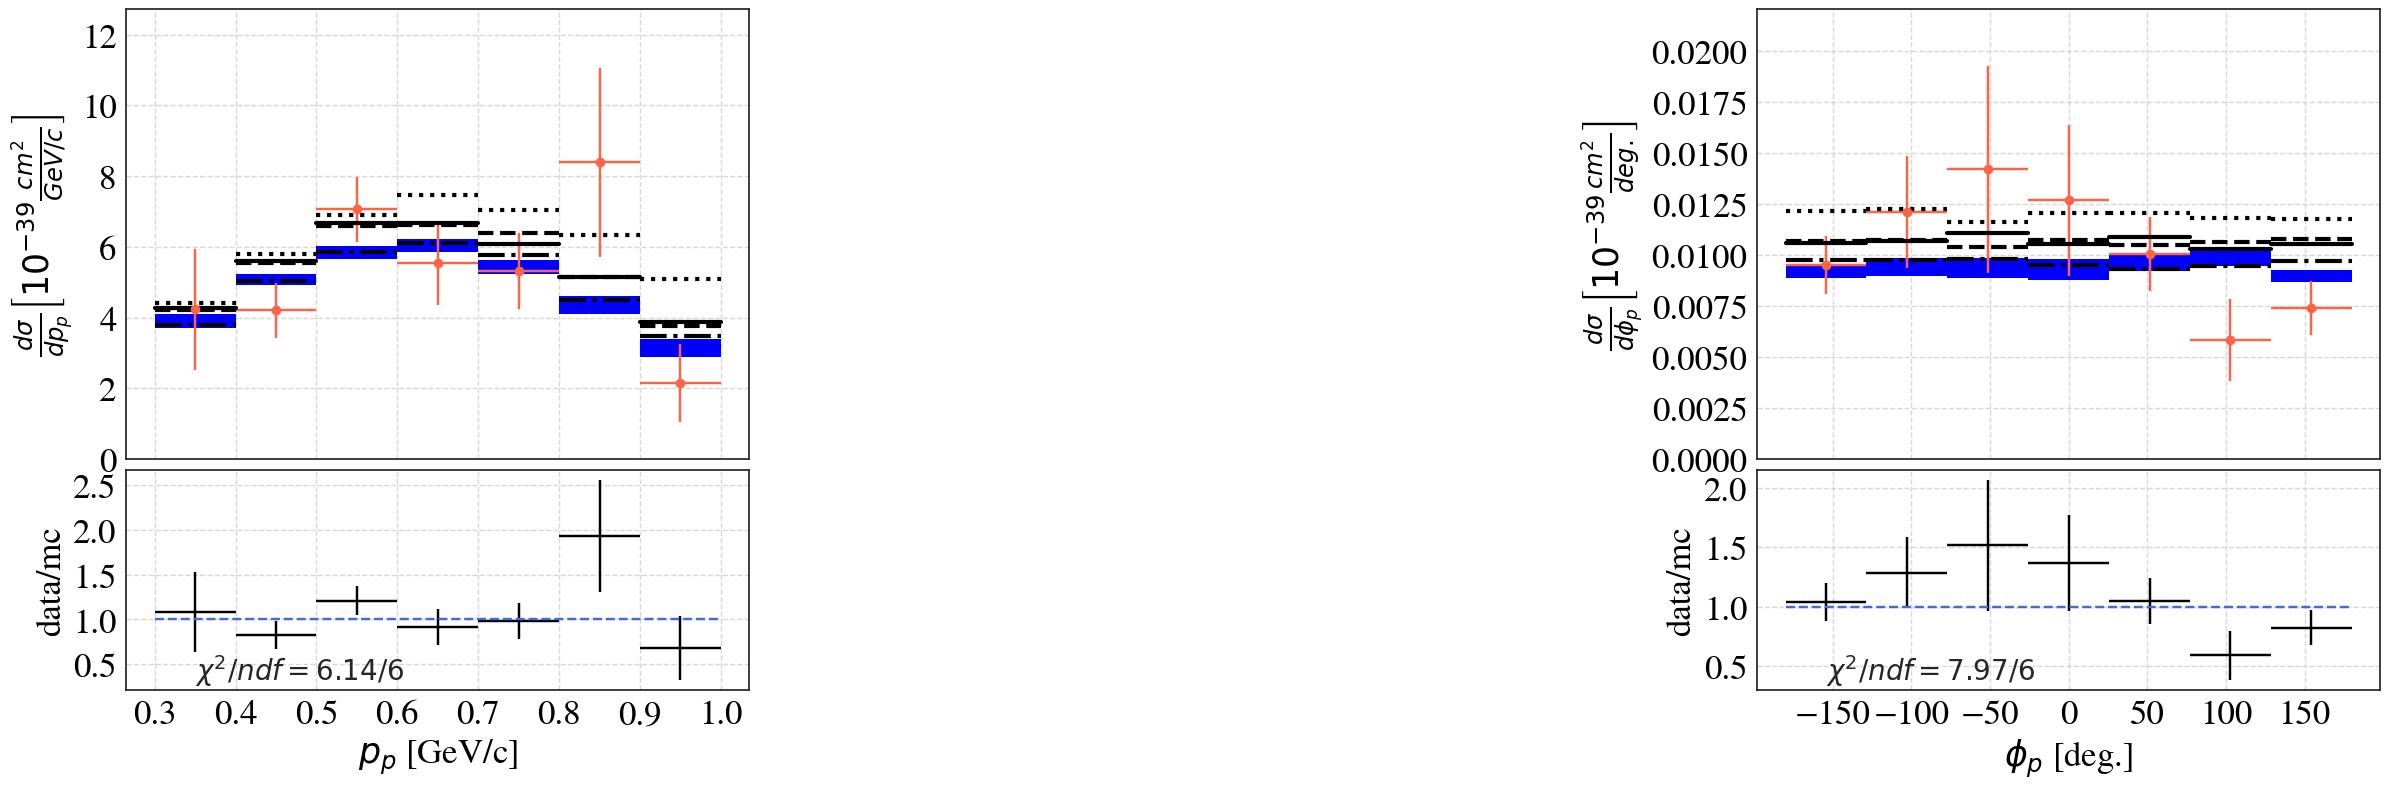

In [28]:
draw_Xsecs(do_add_afro_genie = True,do_corr_phi_0=True,debug=0,do_proton=True,do_P=True,do_phi=True);

## add "beam-on" data with no background subtraction to show cosmic rejection provides an excellent starting point

('integrated Xsec: 4.56+/-0.81', 'mc Xsec: 5.34+/-0.14')
('integrated Xsec: 3.72+/-0.74', 'mc Xsec: 3.54+/-0.12')
nominal afro genie Xsec: 5.75 ± 0.04 e-39 cm2
hA2015 afro genie Xsec: 5.77 ± 0.04 e-39 cm2
hA_SRC afro genie Xsec: 5.16 ± 0.03 e-39 cm2
hA_Tune3 afro genie Xsec: 6.09 ± 0.04 e-39 cm2
without last cos(theta(mu)) bin
nominal afro genie Xsec: 3.83 ± 0.03 e-39 cm2
hA2015 afro genie Xsec: 3.83 ± 0.03 e-39 cm2
hA_SRC afro genie Xsec: 3.46 ± 0.03 e-39 cm2
hA_Tune3 afro genie Xsec: 4.31 ± 0.03 e-39 cm2



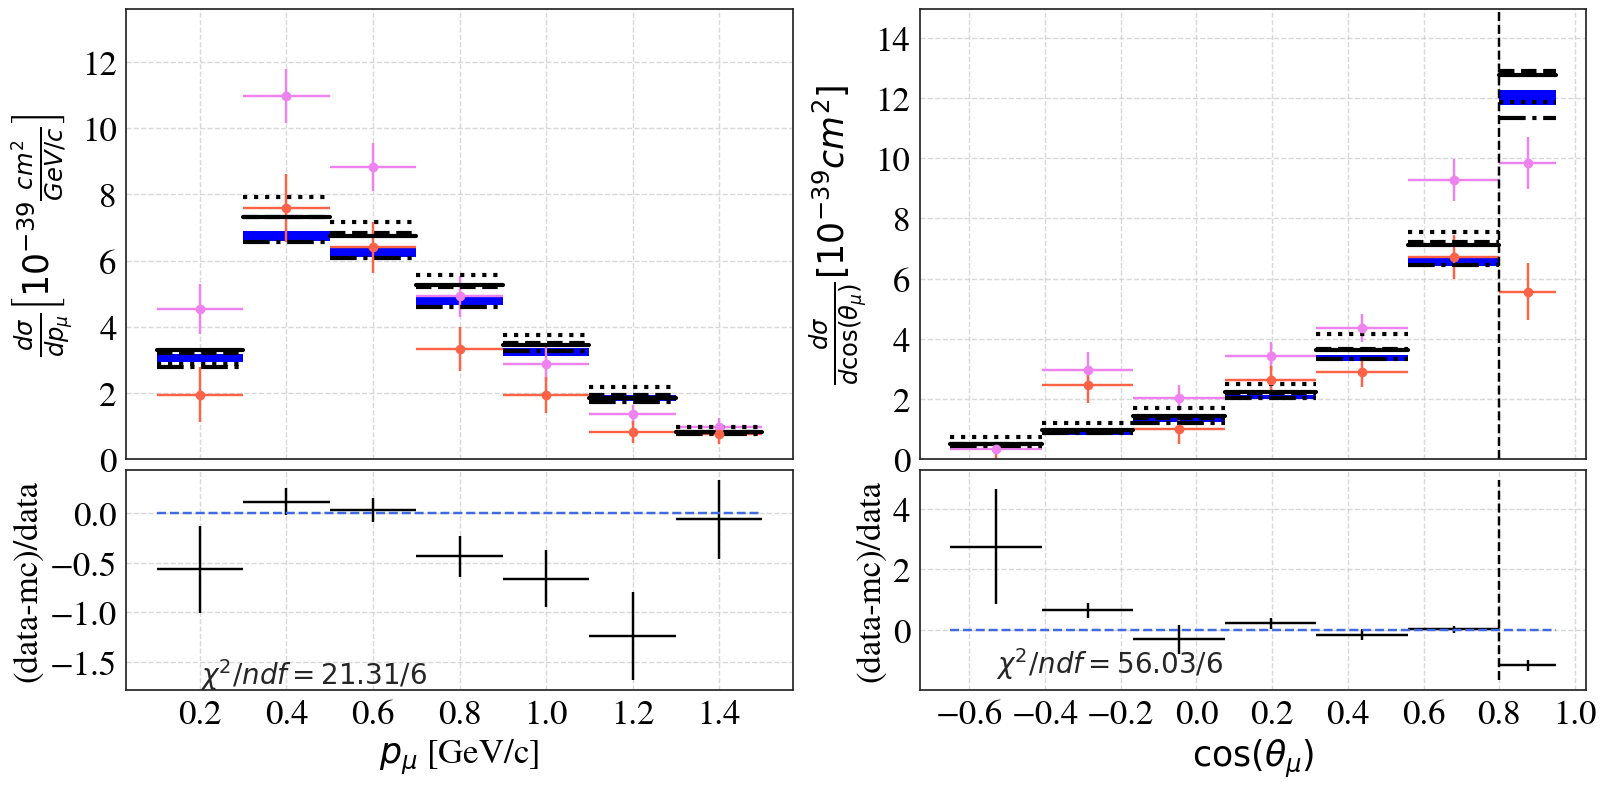

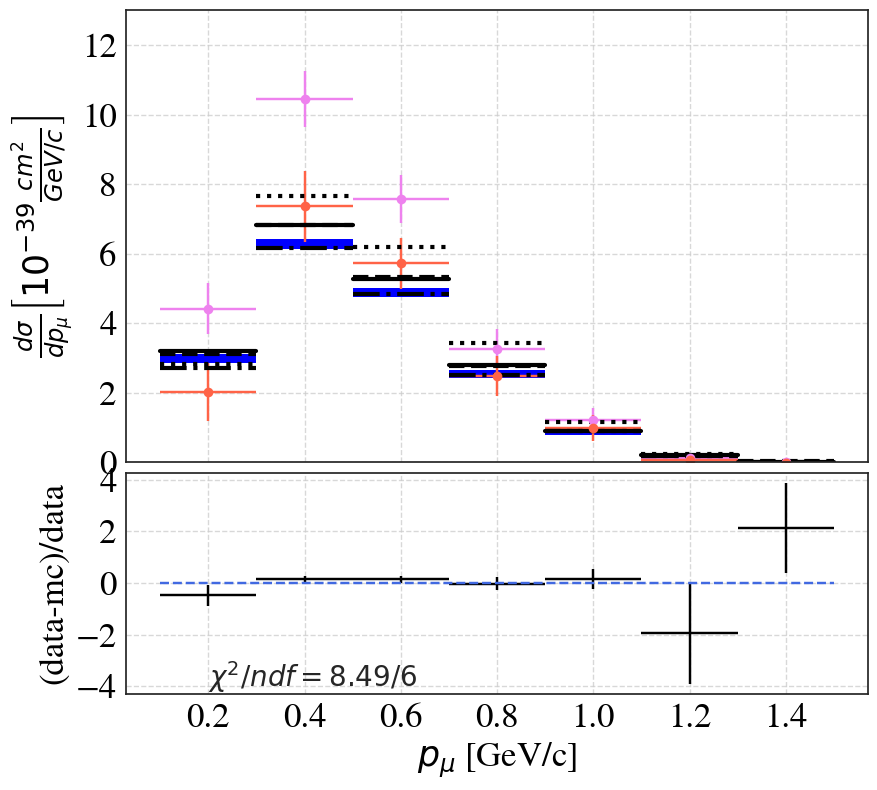

In [38]:
draw_Xsecs(do_add_afro_genie = True,do_corr_phi_0=True,debug=0
           ,do_proton=False,do_P=True,do_phi=False
           ,do_add_beam_on=True);

# 'nominal' cross-section - with no corrections 

('integrated Xsec: 3.99+/-0.81', 'mc Xsec: 5.37+/-0.14')
('integrated Xsec: 3.85+/-1.33', 'mc Xsec: 5.15+/-0.21')
('integrated Xsec: 3.26+/-0.74', 'mc Xsec: 3.56+/-0.12')
('integrated Xsec: 3.19+/-1.24', 'mc Xsec: 3.39+/-0.18')
nominal afro genie Xsec: 5.75 ± 0.04 e-39 cm2
hA2015 afro genie Xsec: 5.77 ± 0.04 e-39 cm2
hA_SRC afro genie Xsec: 5.16 ± 0.03 e-39 cm2
hA_Tune3 afro genie Xsec: 6.09 ± 0.04 e-39 cm2
nominal afro genie Xsec: 5.75 ± 0.04 e-39 cm2
hA2015 afro genie Xsec: 5.77 ± 0.04 e-39 cm2
hA_SRC afro genie Xsec: 5.16 ± 0.03 e-39 cm2
hA_Tune3 afro genie Xsec: 6.09 ± 0.04 e-39 cm2


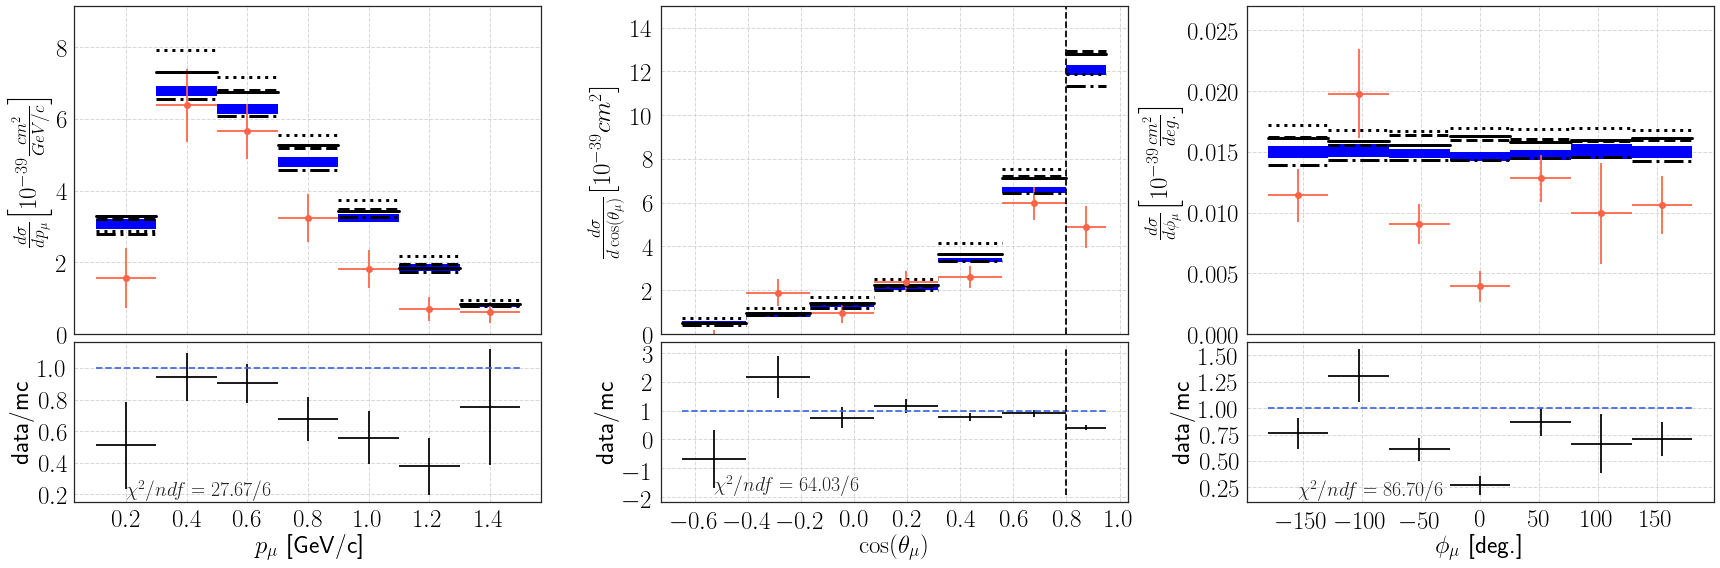

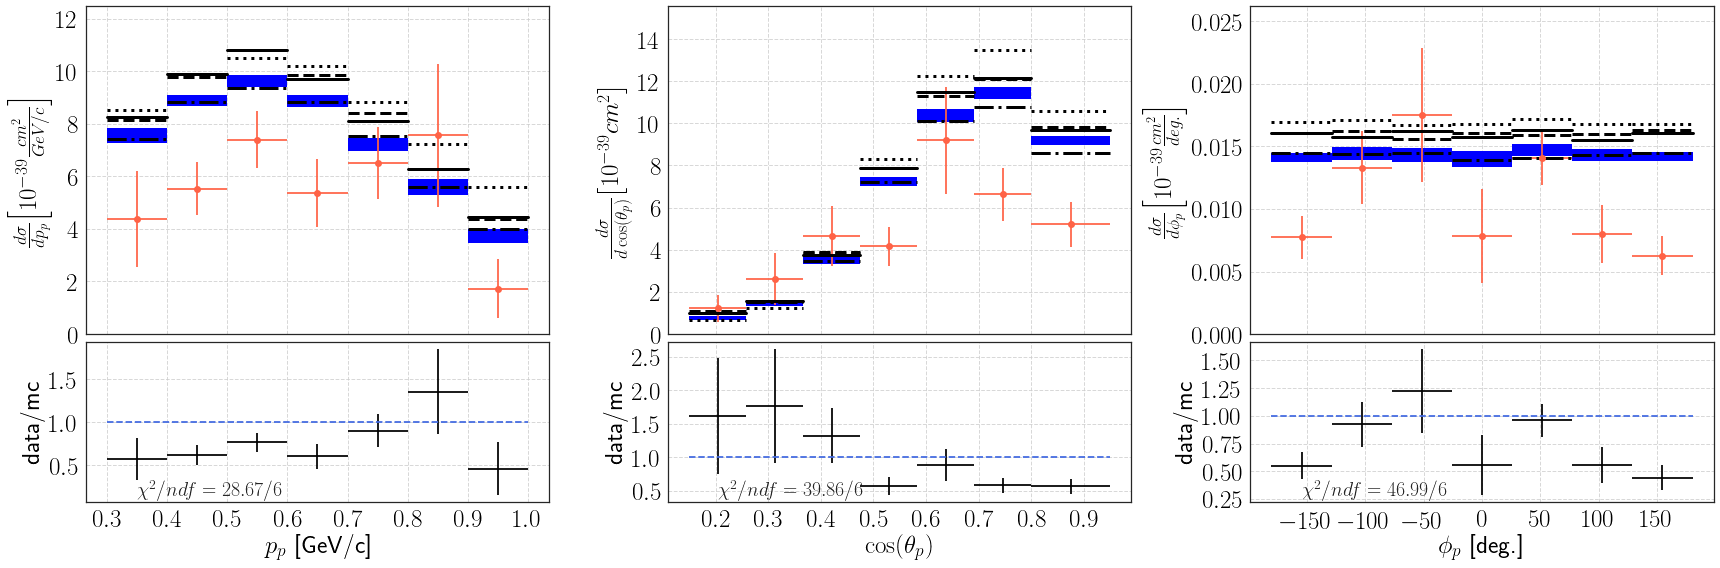

In [89]:
Xsec_dict = draw_Xsecs( do_add_afro_genie=True , do_corr_phi_0=False , debug=0 )